In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
# ========== Dataset ==========
class SteeringDataset(Dataset):
    def __init__(self, images, turn_signals, angles, transform=None):
        self.images = images
        self.turn_signals = turn_signals
        self.labels = self.classify_angles(angles)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        signal = self.turn_signals[idx] + 1  # Map -1,0,1 to 0,1,2
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(signal, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    @staticmethod
    def classify_angles(angles):
        # Bin steering angles into 15 classes
        bins = [-1.01, -0.90, -0.70, -0.30, -0.20, -0.10, -0.05, 0.00, 0.05, 0.10, 0.20, 0.30, 0.70, 0.90, 1.01]
        return np.digitize(angles, bins) - 1  # Result: labels 0 to 6

In [12]:
# ========== Model ==========
class SteeringClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(SteeringClassifier, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()
        self.cnn = resnet
        self.turn_embed = nn.Embedding(3, 16)  # 3 turn signals: -1, 0, 1 -> 0, 1, 2
        self.fc = nn.Sequential(
            nn.Linear(512 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, turn_signal):
        x_img = self.cnn(image)
        x_signal = self.turn_embed(turn_signal)
        x = torch.cat((x_img, x_signal), dim=1)
        return self.fc(x)


In [13]:
# ========== Training ==========
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, save_path="../Models/steering_checkpoint.pth"):
    model.to(device)
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for imgs, signals, labels in train_loader:
            imgs, signals, labels = imgs.to(device), signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, signals, labels in val_loader:
                imgs, signals, labels = imgs.to(device), signals.to(device), labels.to(device)
                outputs = model(imgs, signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }, save_path)

    return train_loss_history, val_loss_history


In [14]:
# ========== Plot ==========
def plot_training_curves(train_loss, val_loss):
    plt.figure()
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# ========== Save Final ==========
def save_final_model(model, path="../Models/steering_model_final.pth"):
    torch.save(model.state_dict(), path)

c:\Users\deyru\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deyru\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\deyru\AppData\Local\Temp\ipykernel_29072\4292606457.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, dtype=torch.float32),


Epoch 1/5 - Train Loss: 0.9859, Val Loss: 1.1238
Epoch 2/5 - Train Loss: 0.5851, Val Loss: 1.0640
Epoch 3/5 - Train Loss: 0.4839, Val Loss: 1.2265
Epoch 4/5 - Train Loss: 0.4054, Val Loss: 1.2593
Epoch 5/5 - Train Loss: 0.3266, Val Loss: 1.2993


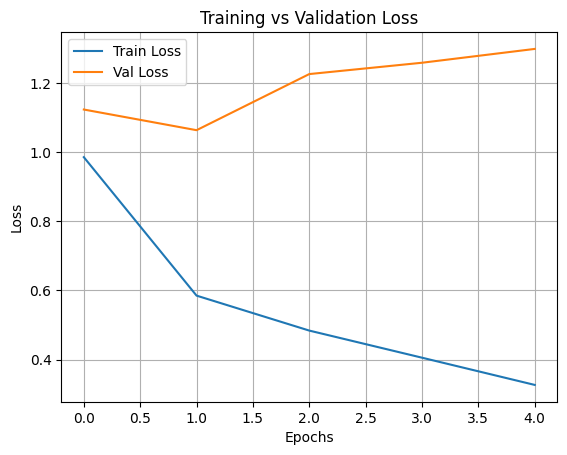

In [16]:
# ========== Main ==========
if __name__ == "__main__":
    # Load data
    images = np.load("../output/std_images.npy")               # shape (N, 3, H, W) or (N, H, W, 3)
    turn_signals = np.load("../output/std_turn_signals.npy")   # values: -1, 0, 1
    angles = np.load("../output/std_angles.npy")               # values: -1.0 to 1.0

    # Fix image shape if needed
    if images.ndim == 4 and images.shape[1] == 3:
        images = np.transpose(images, (0, 2, 3, 1))  # to HWC

    # Normalize for uint8 display (optional)
    if images.max() <= 1.0:
        images = (images * 255).astype(np.uint8)
    else:
        images = images.astype(np.uint8)

    # Transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # # Split data
    # X_train, X_val, s_train, s_val, a_train, a_val = train_test_split(
    #     images, turn_signals, angles, test_size=0.2, random_state=42
    # )

    split_idx = int(0.8 * len(images))
    X_train, X_val = images[:split_idx], images[split_idx:]
    s_train, s_val = turn_signals[:split_idx], turn_signals[split_idx:]
    a_train, a_val = angles[:split_idx], angles[split_idx:]

    # Datasets and Loaders
    train_dataset = SteeringDataset(X_train, s_train, a_train, transform)
    val_dataset = SteeringDataset(X_val, s_val, a_val, transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model, Optimizer, Loss
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SteeringClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train
    train_loss, val_loss = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, device,
        num_epochs=5, save_path="../Models/steering_checkpoint.pth"
    )

    # Plot and Save
    plot_training_curves(train_loss, val_loss)
    save_final_model(model, "../Models/steering_model_final.pth")